In [67]:
%matplotlib inline
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`current_injection-users.ipynb`**. See the button at the top right to download as markdown or pdf.
:::
# Introduction to GLM
This notebook has had all its explanatory text removed and has not been run.
 It is intended to be downloaded and run locally (or on the provided binder)
 while listening to the presenter's explanation. In order to see the fully
 rendered of this notebook, go [here](../../full/day2/current_injection.md)

Data for this notebook is a patch clamp experiment with a mouse V1 neuron, from the [Allen Brain Atlas](https://celltypes.brain-map.org/experiment/electrophysiology/478498617)

![Allen Brain Atlas view of the data we will analyze.](../../docs/source/_static/allen_data.png)


## Learning objectives 

- Learn how to explore spiking data and do basic analyses using pynapple
- Learn how to structure data for NeMoS
- Learn how to fit a basic Generalized Linear Model using NeMoS
- Learn how to retrieve the parameters and predictions from a fit GLM for
  intrepetation.

In [68]:
# Import everything
import jax
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots
import workshop_utils

# configure plots some
plt.style.use(nmo.styles.plot_style)

## Data Streaming

- Stream the data. Format is [Neurodata Without Borders (NWB) standard](https://nwb-overview.readthedocs.io/en/latest/)

In [69]:
path = workshop_utils.fetch_data("allen_478498617.nwb")

## Pynapple
### Data structures and preparation

- Open the NWB file with [pynapple](https://pynapple-org.github.io/pynapple/)

In [70]:
data = nap.load_file(path)
print(data)

allen_478498617
┍━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys     │ Type        │
┝━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units    │ TsGroup     │
│ epochs   │ IntervalSet │
│ stimulus │ Tsd         │
│ response │ Tsd         │
┕━━━━━━━━━━┷━━━━━━━━━━━━━┙


/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


![Annotated view of the data we will analyze.](../../docs/source/_static/allen_data_annotated.gif)
<!-- this gif created with the following imagemagick command: convert -layers OptimizePlus -delay 100 allen_data_annotated-units.svg allen_data_annotated-epochs.svg allen_data_annotated-stimulus.svg allen_data_annotated-response.svg -loop 0 allen_data_annotated.gif -->

- `stimulus`: injected current, in Amperes, sampled at 20k Hz.
- `response`: the neuron's intracellular voltage, sampled at 20k Hz. We will not use this info in this example.
- `units`: dictionary of neurons, holding each neuron's spike timestamps.
- `epochs`: start and end times of different intervals, defining the experimental structure, specifying when each stimulation protocol began and ended.

In [5]:
trial_interval_set = data["epochs"]

current = data["stimulus"]
spikes = data["units"]

In [6]:
trial_interval_set

index    start    end      tags
0        0.0      34.02    ['Ramp']
1        39.02    73.04    ['Ramp']
2        78.04    112.06   ['Ramp']
3        117.06   119.083  ['Short Square']
4        124.083  126.106  ['Short Square']
5        131.106  133.129  ['Short Square']
6        138.129  140.152  ['Short Square']
...      ...      ...      ...
60       0.0      34.02    ['Short Square - Triple']
61       39.02    73.04    ['Short Square - Triple']
62       78.04    112.06   ['Short Square - Triple']
63       117.06   119.083  ['Short Square - Triple']
64       124.083  126.106  ['Short Square - Triple']
65       131.106  133.129  ['Short Square - Triple']
66       138.129  140.152  ['Test']
shape: (67, 2), time unit: sec.

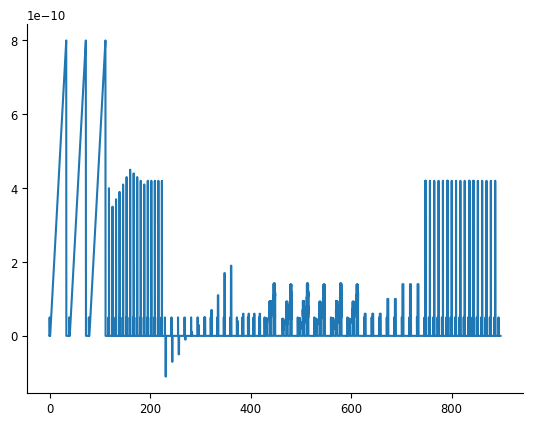

In [7]:
plt.figure()
plt.plot(current)

- `Noise 1`: epochs of random noise

In [8]:
noise_interval = trial_interval_set[trial_interval_set.tags == "Noise 1"]
noise_interval

  index    start      end  tags
      0  460.768  488.788  ['Noise 1']
      1  526.808  554.828  ['Noise 1']
      2  592.848  620.868  ['Noise 1']
shape: (3, 2), time unit: sec.

- Let's focus on the first epoch.

In [9]:
noise_interval = noise_interval[0]
noise_interval

  index    start      end  tags
      0  460.768  488.788  Noise 1
shape: (1, 2), time unit: sec.

- `current` : Tsd (TimeSeriesData) : time index + data

In [10]:
current

Time (s)
-------------  --
0.0             0
5e-05           0
0.0001          0
0.00015         0
0.0002          0
0.00025         0
0.0003          0
...
897.420649999   0
897.420699999   0
897.420749999   0
897.420799999   0
897.420849999   0
897.420899999   0
897.420949999   0
dtype: float64, shape: (11348420,)

- `restrict` : restricts a time series object to a set of time intervals delimited by an IntervalSet object

In [11]:
current = current.restrict(noise_interval)
# convert current from Ampere to pico-amperes, to match the above visualization
# and move the values to a more reasonable range.
current = current * 1e12
current

Time (s)
-------------  --
460.768         0
460.76805       0
460.7681        0
460.76815       0
460.7682        0
460.76825       0
460.7683        0
...
488.787649993   0
488.787699993   0
488.787749993   0
488.787799993   0
488.787849993   0
488.787899993   0
488.787949993   0
dtype: float64, shape: (560400,)

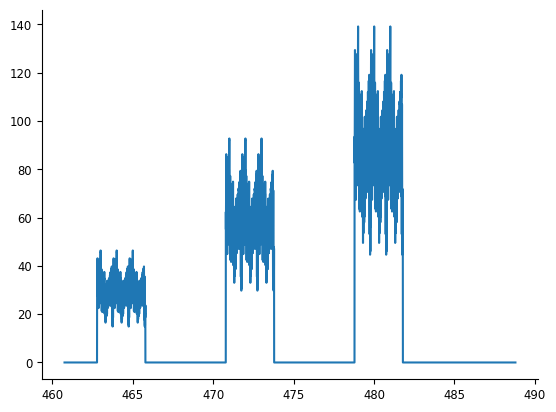

In [12]:
plt.plot(current)

- `TsGroup` : a dictionary-like object holding multiple `Ts` (timeseries) objects with potentially different time indices.

In [13]:
spikes

  Index     rate  location      group
-------  -------  ----------  -------
      0  0.87805  v1                0

We can index into the `TsGroup` to see the timestamps for this neuron's spikes:

In [14]:
spikes[0]

Time (s)
1.85082
2.06869
2.20292
2.325815
2.42342
2.521415
2.604795
...
869.461695
878.08481
878.09765
878.110865
886.75375
886.761465
886.76995
shape: 777

Let's restrict to the same epoch `noise_interval`:

In [15]:
spikes = spikes.restrict(noise_interval)
print(spikes)
spikes[0]

  Index     rate  location      group
-------  -------  ----------  -------
      0  1.42755  v1                0


Time (s)
470.81754
470.85842
470.907235
470.954925
471.0074
471.107175
471.25083
...
480.67927
480.81817
480.90529
480.94921
481.002715
481.60008
481.67727
shape: 40

Let's visualize the data from this trial:

Text(0.5, 0, 'Time (s)')

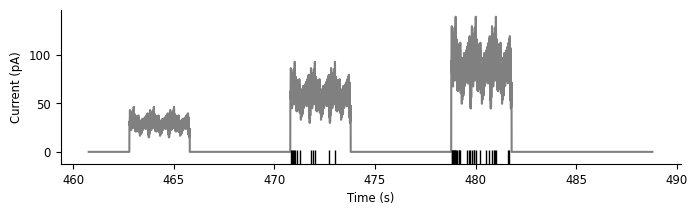

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(current, "grey")
ax.plot(spikes.to_tsd([-5]), "|", color="k", ms = 10)
ax.set_ylabel("Current (pA)")
ax.set_xlabel("Time (s)")

### Basic analyses

The Generalized Linear Model gives a predicted firing rate. First we can use pynapple to visualize this firing rate for a single trial.

- `count` : count the number of events within `bin_size`

In [17]:
# bin size in seconds
bin_size = 0.001
# Get spikes for neuron 0
count = spikes[0].count(bin_size)
count

Time (s)
----------  --
460.7685     0
460.7695     0
460.7705     0
460.7715     0
460.7725     0
460.7735     0
460.7745     0
...
488.7815     0
488.7825     0
488.7835     0
488.7845     0
488.7855     0
488.7865     0
488.7875     0
dtype: int64, shape: (28020,)

Let's convert the spike counts to firing rate :

- `smooth` : convolve with a Gaussian kernel

In [18]:
# the inputs to this function are the standard deviation of the gaussian in seconds and
# the full width of the window, in standard deviations. So std=.05 and size_factor=20
# gives a total filter size of 0.05 sec * 20 = 1 sec.
firing_rate = count.smooth(std=0.05, size_factor=20)
# convert from spikes per bin to spikes per second (Hz)
firing_rate = firing_rate / bin_size

In [19]:
print(type(firing_rate))

<class 'pynapple.core.time_series.Tsd'>


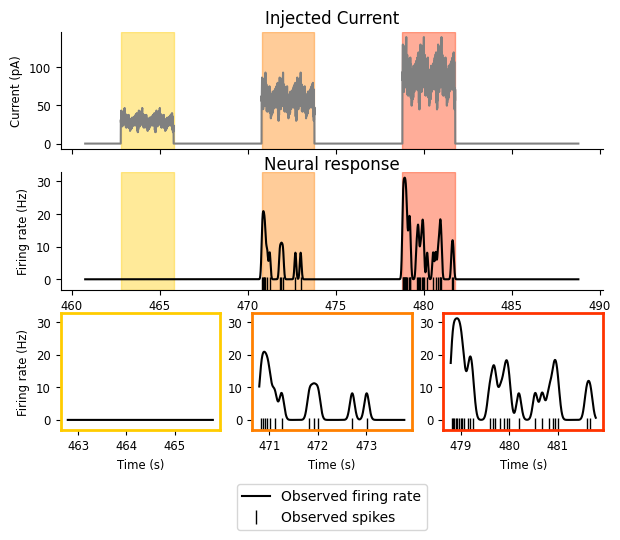

In [20]:
doc_plots.current_injection_plot(current, spikes, firing_rate);

What is the relationship between the current and the spiking activity?
[`compute_1d_tuning_curves`](https://pynapple-org.github.io/pynapple/reference/process/tuning_curves/#pynapple.process.tuning_curves.compute_1d_tuning_curves) : compute the firing rate as a function of a 1-dimensional feature.

In [21]:
tuning_curve = nap.compute_1d_tuning_curves(spikes, current, nb_bins=15)
tuning_curve

,0
4.637500,0.000000
13.912500,0.000000
23.187501,0.000000
32.462501,0.000000
41.737501,0.000000
51.012501,0.000000
60.287501,3.960592
69.562502,1.755310
78.837502,4.294610
88.112502,10.993325


Let's plot the tuning curve of the neuron.

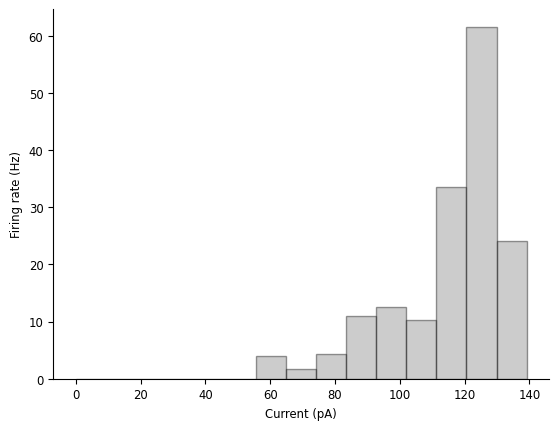

In [22]:
doc_plots.tuning_curve_plot(tuning_curve);

## NeMoS 
### Preparing data

Get data from pynapple to NeMoS-ready format:

- predictors and spikes must have same number of time points

In [23]:
current.shape

(560400,)

In [24]:
count.shape

(28020,)

In [25]:
# Let's downsample the current to match the count
binned_current = current.bin_average(bin_size)

In [26]:
bin_size

0.001

In [27]:
binned_current.shape

(28020,)

- predictors must be 2d, spikes 1d

In [28]:
#binned_current = nap.TsdFrame(t=binned_current.t, d=binned_current)
binned_current = np.expand_dims(binned_current, 1)

In [29]:
binned_current

Time (s)    0
----------  ---
460.7685    0.0
460.7695    0.0
460.7705    0.0
460.7715    0.0
460.7725    0.0
460.7735    0.0
460.7745    0.0
...         ...
488.7815    0.0
488.7825    0.0
488.7835    0.0
488.7845    0.0
488.7855    0.0
488.7865    0.0
488.7875    0.0
dtype: float64, shape: (28020, 1)

### Fitting the model

- GLM objects need regularizers and observation models

In [30]:
model = nmo.glm.GLM(solver_name='LBFGS')

- call fit and retrieve parameters

In [31]:
model.fit(binned_current, count)

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

- generate and examine model predictions.

In [32]:
print(f"exp{model.coef_} * current(T) + {model.intercept_}")

exp[0.05330383] * current(T) + [-9.761143]


In [33]:
yhat = model.predict(binned_current)  / bin_size

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(


In [34]:
yhat

Time (s)
----------  ---------
460.7685    0.0576487
460.7695    0.0576487
460.7705    0.0576487
460.7715    0.0576487
460.7725    0.0576487
460.7735    0.0576487
460.7745    0.0576487
...
488.7815    0.0576487
488.7825    0.0576487
488.7835    0.0576487
488.7845    0.0576487
488.7855    0.0576487
488.7865    0.0576487
488.7875    0.0576487
dtype: float32, shape: (28020,)

- what do we see?

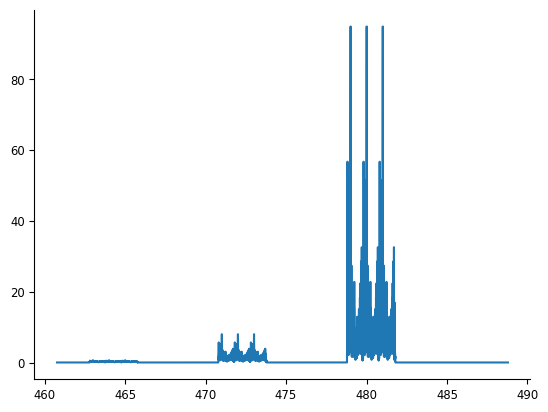

In [35]:
fig, ax = plt.subplots(1,1)
ax.plot(yhat)

In [36]:
smooth_pred_fr = yhat.smooth(0.05, size_factor=20)

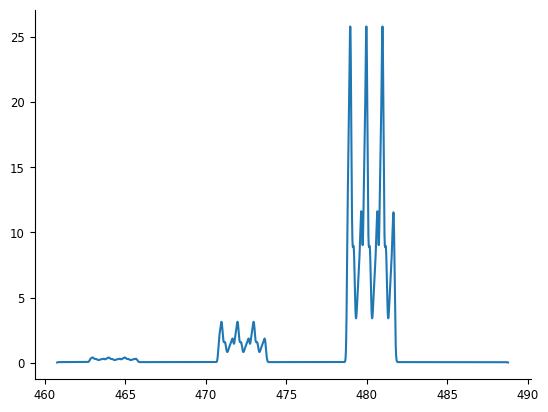

In [37]:
plt.plot(smooth_pred_fr)

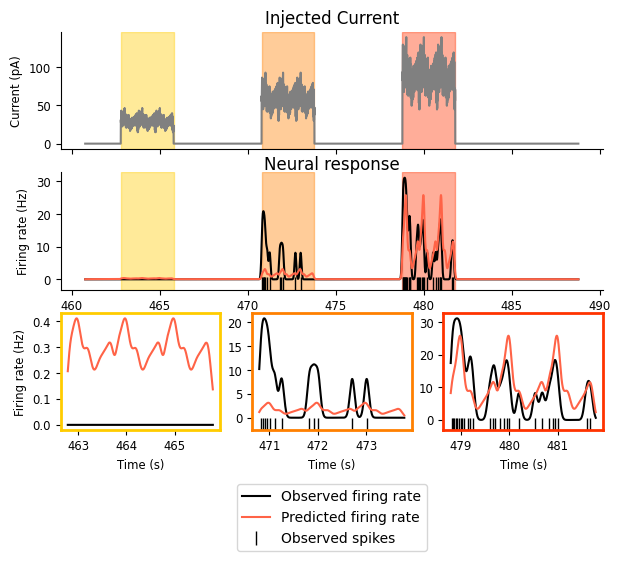

In [38]:
fig = doc_plots.current_injection_plot(current, spikes, firing_rate, predicted_firing_rate=smooth_pred_fr)

- examine tuning curve &mdash; what do we see?

In [39]:
tuning_curve_pred = nap.compute_1d_tuning_curves_continuous(smooth_pred_fr, binned_current, nb_bins=30)

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


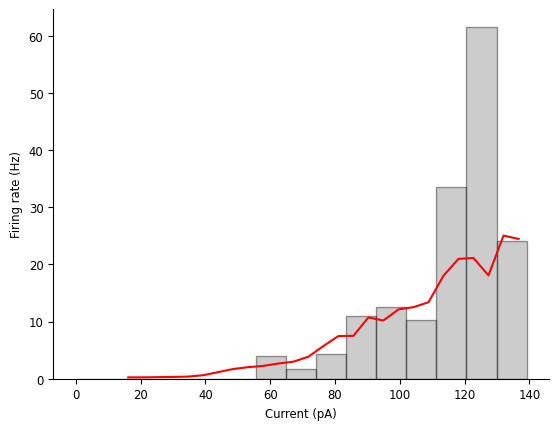

In [40]:
fig = doc_plots.tuning_curve_plot(tuning_curve);
fig.axes[0].plot(tuning_curve_pred, 'r', label='glm')

### Extending the model to use injection history

  - choose a length of time over which the neuron integrates the input current

In [41]:
current_history_duration_sec = .2
# convert this from sec to bins
current_history_duration = int(current_history_duration_sec / bin_size)

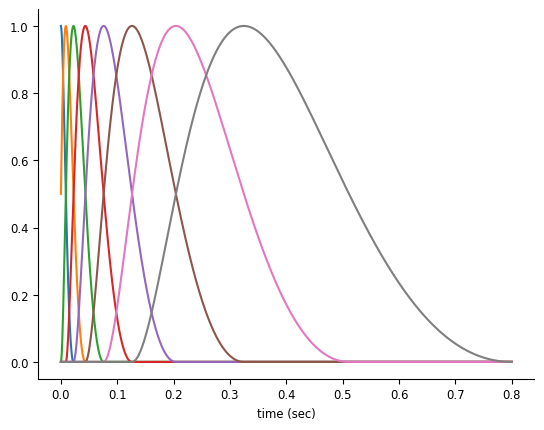

In [42]:
doc_plots.plot_basis();

  - define a basis object

In [43]:
basis = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=10, window_size=current_history_duration,
)

In [44]:
current_history = basis.compute_features(binned_current)

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/core/time_series.py:300: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  out = func._implementation(*new_args, **kwargs)


  - create the design matrix
  - examine the features it contains

In [45]:
current_history

Time (s)    0    1    2    3    4    ...
----------  ---  ---  ---  ---  ---  -----
460.7685    nan  nan  nan  nan  nan  ...
460.7695    nan  nan  nan  nan  nan  ...
460.7705    nan  nan  nan  nan  nan  ...
460.7715    nan  nan  nan  nan  nan  ...
460.7725    nan  nan  nan  nan  nan  ...
460.7735    nan  nan  nan  nan  nan  ...
460.7745    nan  nan  nan  nan  nan  ...
...         ...  ...  ...  ...  ...  ...
488.7815    0.0  0.0  0.0  0.0  0.0  ...
488.7825    0.0  0.0  0.0  0.0  0.0  ...
488.7835    0.0  0.0  0.0  0.0  0.0  ...
488.7845    0.0  0.0  0.0  0.0  0.0  ...
488.7855    0.0  0.0  0.0  0.0  0.0  ...
488.7865    0.0  0.0  0.0  0.0  0.0  ...
488.7875    0.0  0.0  0.0  0.0  0.0  ...
dtype: float32, shape: (28020, 10)

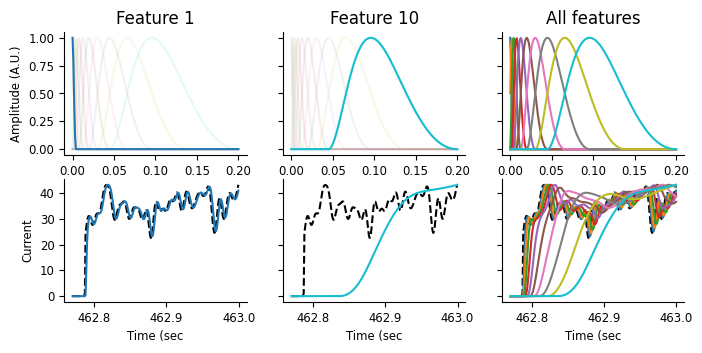

In [46]:
# in this plot, we're normalizing the amplitudes to make the comparison easier --
# the amplitude of these features will be fit by the model, so their un-scaled
# amplitudes is not informative
workshop_utils.plot_current_history_features(binned_current, current_history, basis,
                                             current_history_duration_sec)

  - create and fit the GLM
  - examine the parameters

In [47]:
history_model = nmo.glm.GLM(solver_name='LBFGS')

In [48]:
history_model.fit(current_history, count)

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS'
)

In [49]:
history_pred_fr = history_model.predict(current_history)
smooth_predicted_fr = smooth_pred_fr

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(


In [50]:
print(f"firing_rate(t) = exp({history_model.coef_} * current(t) + {history_model.intercept_})")

firing_rate(t) = exp([-0.18239757  0.19256012 -0.08882547  0.02926374 -0.00101938 -0.00541549
  0.00264424 -0.00147817  0.00111308 -0.00063025] * current(t) + [-7.5384316])


  - compare the predicted firing rate to the data and the old model
  - what do we see?

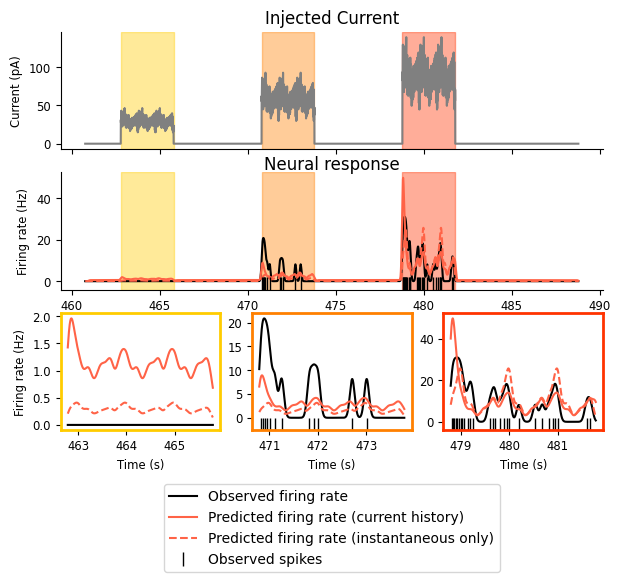

In [51]:
# all this code is the same as above
history_pred_fr = history_model.predict(current_history)
history_pred_fr = history_pred_fr / bin_size
smooth_history_pred_fr = history_pred_fr.dropna().smooth(.05, size_factor=20)
workshop_utils.current_injection_plot(current, spikes, firing_rate,
                                      # compare against the old firing rate
                                      smooth_history_pred_fr, smooth_predicted_fr)

  - examine the predicted average firing rate and tuning curve
  - what do we see?

In [52]:
# enter code here
tuning_curve_model = tuning_curve_pred

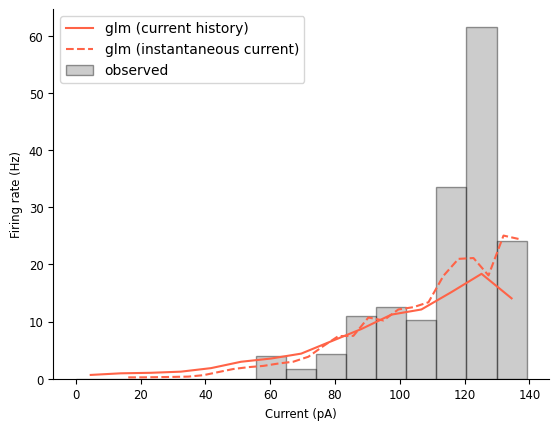

In [53]:
# Visualize tuning curve
tuning_curve_history_model = nap.compute_1d_tuning_curves_continuous(smooth_history_pred_fr, current, 15)
fig = doc_plots.tuning_curve_plot(tuning_curve)
fig.axes[0].plot(tuning_curve_history_model, color="tomato", label="glm (current history)")
fig.axes[0].plot(tuning_curve_model, color="tomato", linestyle='--', label="glm (instantaneous current)")
fig.axes[0].legend()

  - use log-likelihood to compare models

In [54]:
history_model.score(current_history, count)

Array(-0.00820689, dtype=float32)

In [58]:
model.score(binned_current, count)

Array(-0.00793992, dtype=float32)

### Finishing up

  - what if you want to compare models across datasets?

In [63]:
jax.random.poisson(jax.random.PRNGKey(123), np.nan)

Array(-1, dtype=int32)

In [66]:
np.random.poisson(np.nan)

ValueError: lam < 0 or lam is NaN

- what about spiking?

In [60]:
history_pred_spikes = jax.random.poisson(jax.random.PRNGKey(123), history_pred_fr.values)

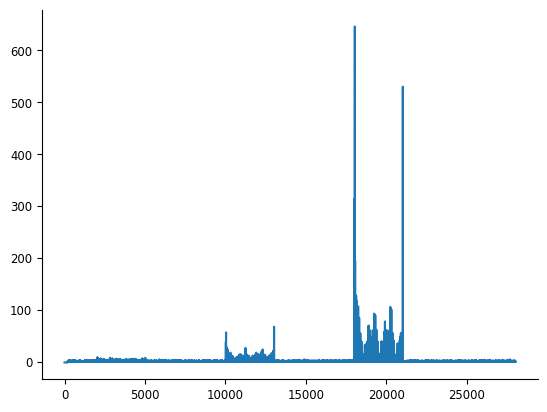

In [61]:
plt.plot(history_pred_spikes)

## Further Exercises 

- what else can we do?


### Data citation

The data used in this tutorial is from the **Allen Brain Map**, with the [following citation](https://knowledge.brain-map.org/data/1HEYEW7GMUKWIQW37BO/summary):

**Contributors:** Agata Budzillo, Bosiljka Tasic, Brian R. Lee, Fahimeh Baftizadeh, Gabe Murphy, Hongkui Zeng, Jim Berg, Nathan Gouwens, Rachel Dalley, Staci A. Sorensen, Tim Jarsky, Uygar Sümbül Zizhen Yao

**Dataset:** Allen Institute for Brain Science (2020). Allen Cell Types Database -- Mouse Patch-seq [dataset]. Available from brain-map.org/explore/classes/multimodal-characterization.

**Primary publication:** Gouwens, N.W., Sorensen, S.A., et al. (2020). Integrated morphoelectric and transcriptomic classification of cortical GABAergic cells. Cell, 183(4), 935-953.E19. https://doi.org/10.1016/j.cell.2020.09.057

**Patch-seq protocol:** Lee, B. R., Budzillo, A., et al. (2021). Scaled, high fidelity electrophysiological, morphological, and transcriptomic cell characterization. eLife, 2021;10:e65482. https://doi.org/10.7554/eLife.65482

**Mouse VISp L2/3 glutamatergic neurons:** Berg, J., Sorensen, S. A., Miller, J., Ting, J., et al. (2021) Human neocortical expansion involves glutamatergic neuron diversification. Nature, 598(7879):151-158. doi: 10.1038/s41586-021-03813-8